In [1]:
#Importing the basic librarires

import math
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

#from brokenaxes import brokenaxes
from statsmodels.formula import api
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10,6]

import warnings 
warnings.filterwarnings('ignore')

In [3]:
#Importing the dataset

df = pd.read_csv('Student_Marks.csv')

#df.drop(['car name'], axis=1, inplace=True)
display(df.head())

target = 'Marks'
features = [i for i in df.columns if i not in [target]]

original_df = df.copy(deep=True)

print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

,number_courses,time_study,Marks
0,3,4.508,19.202
1,4,0.096,7.734
2,4,3.133,13.811
3,6,7.909,53.018
4,8,7.811,55.299



Inference: The Datset consists of 3 features & 100 samples.


In [4]:
#Checking the dtypes of all the columns

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   number_courses  100 non-null    int64  
 1   time_study      100 non-null    float64
 2   Marks           100 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 2.5 KB


In [5]:
#Checking number of unique rows in each feature

df.nunique().sort_values()

number_courses      6
time_study        100
Marks             100
dtype: int64

In [6]:
#Checking number of unique rows in each feature

nu = df[features].nunique().sort_values()
nf = []; cf = []; nnf = 0; ncf = 0; #numerical & categorical features

for i in range(df[features].shape[1]):
    if nu.values[i]<=16:cf.append(nu.index[i])
    else: nf.append(nu.index[i])

print('\n\033[1mInference:\033[0m The Datset has {} numerical & {} categorical features.'.format(len(nf),len(cf)))


Inference: The Datset has 1 numerical & 1 categorical features.


In [7]:
#Checking the stats of all the columns

display(df.describe())

,number_courses,time_study,Marks
count,100.000000,100.000000,100.000000
mean,5.290000,4.077140,24.417690
std,1.799523,2.372914,14.326199
min,3.000000,0.096000,5.609000
25%,4.000000,2.058500,12.633000
50%,5.000000,4.022000,20.059500
75%,7.000000,6.179250,36.676250
max,8.000000,7.957000,55.299000


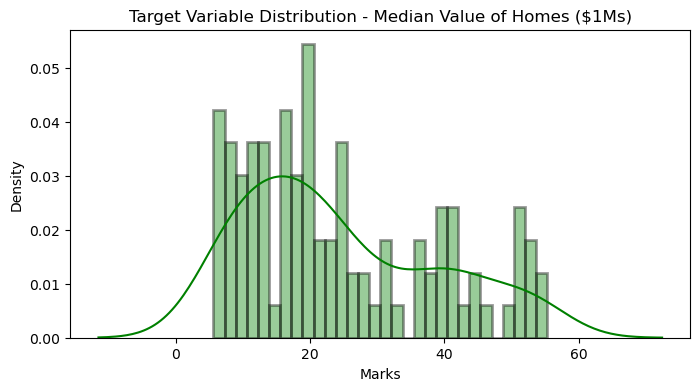

In [8]:
#Exploratory Data Analysis (EDA)
#Let us first analyze the distribution of the target variable

plt.figure(figsize=[8,4])
sns.distplot(df[target], color='g',hist_kws=dict(edgecolor="black", linewidth=2), bins=30)
plt.title('Target Variable Distribution - Median Value of Homes ($1Ms)')
plt.show()

                Visualising Categorical Features:                 


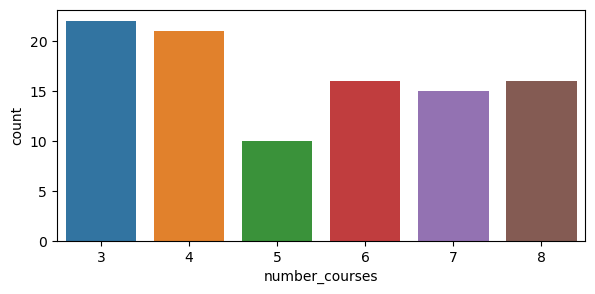

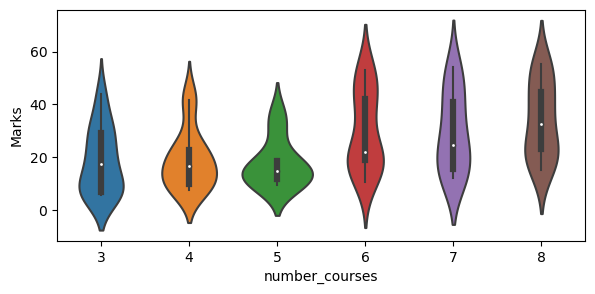

In [9]:
#Visualising the categorical features 

print('\033[1mVisualising Categorical Features:'.center(70))

n=2
plt.figure(figsize=[15,3])

for i in range(len(cf)):
    plt.subplot(math.ceil(len(cf)/n),n,i+1)
    sns.countplot(df[cf[i]])
plt.show()

plt.figure(figsize=[15,3])
for i in range(len(cf)):
    plt.subplot(math.ceil(len(cf)/n),n,i+1)
    sns.violinplot(x=df[cf[i]], y=df[target])
#plt.tight_layout()
plt.show()

                  Numeric Features Distribution                   


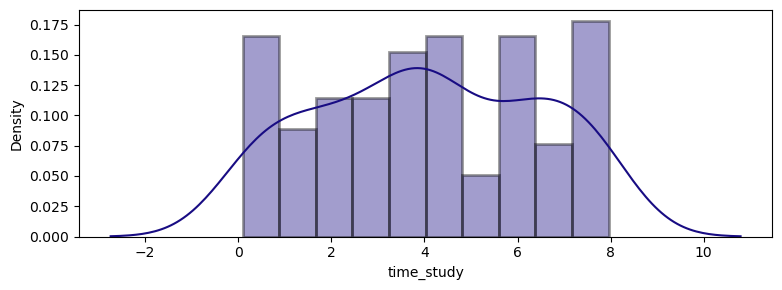

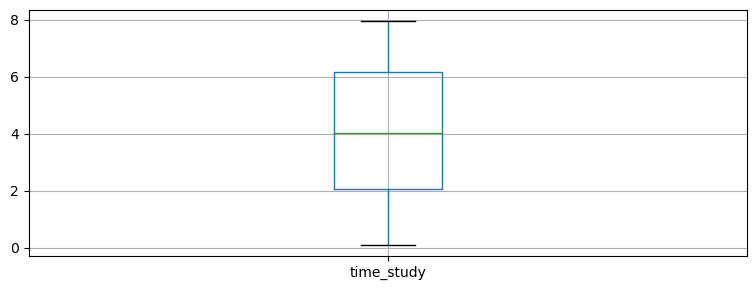

In [10]:
#Visualising the numeric features 

print('\033[1mNumeric Features Distribution'.center(70))

n=2

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    sns.distplot(df[nf[i]],hist_kws=dict(edgecolor="black", linewidth=2), bins=10, color=list(np.random.randint([255,255,255])/255))
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,3*math.ceil(len(nf)/n)])
for i in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/3),n,i+1)
    df.boxplot(nf[i])
plt.tight_layout()
plt.show()

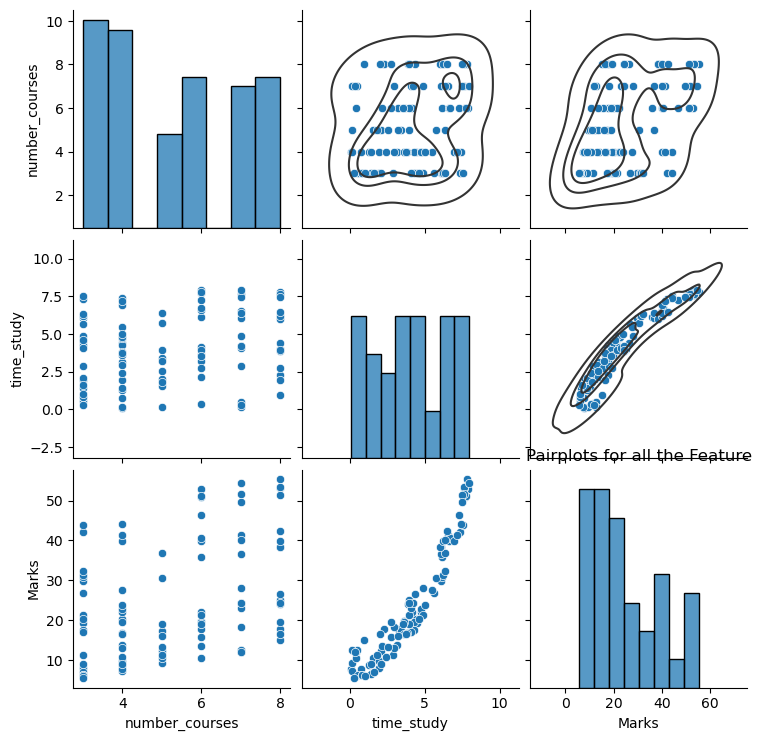

In [11]:
#Understanding the relationship between all the features

g = sns.pairplot(df)
plt.title('Pairplots for all the Feature')
g.map_upper(sns.kdeplot, levels=4, color=".2")
plt.show()

In [12]:
#Data Preprocessing
#Removal of any Duplicate rows (if any)

counter = 0
rs,cs = original_df.shape

df.drop_duplicates(inplace=True)

if df.shape==(rs,cs):
    print('\n\033[1mInference:\033[0m The dataset doesn\'t have any duplicates')
else:
    print(f'\n\033[1mInference:\033[0m Number of duplicates dropped/fixed ---> {rs-df.shape[0]}')


Inference: The dataset doesn't have any duplicates


In [13]:
#Check for empty elements

nvc = pd.DataFrame(df.isnull().sum().sort_values(), columns=['Total Null Values'])
nvc['Percentage'] = round(nvc['Total Null Values']/df.shape[0],3)*100
print(nvc)

                Total Null Values  Percentage
number_courses                  0         0.0
time_study                      0         0.0
Marks                           0         0.0


In [14]:
#Converting categorical Columns to Numeric

df3 = df.copy()

ecc = nvc[nvc['Percentage']!=0].index.values
fcc = [i for i in cf if i not in ecc]
fcc.remove('number_courses')
#One-Hot Binay Encoding
oh=True
dm=True
for i in fcc:
    #print(i)
    if df3[i].nunique()==2:
        if oh==True: print("\033[1mOne-Hot Encoding on features:\033[0m")
        print(i);oh=False
        df3[i]=pd.get_dummies(df3[i], drop_first=True, prefix=str(i))
    if (df3[i].nunique()>2 and df3[i].nunique()<17):
        if dm==True: print("\n\033[1mDummy Encoding on features:\033[0m")
        print(i);dm=False
        df3 = pd.concat([df3.drop([i], axis=1), pd.DataFrame(pd.get_dummies(df3[i], drop_first=True, prefix=str(i)))],axis=1)
        
df3.shape

(100, 3)

In [15]:
#Removal of outlier:

df1 = df3.copy()

#features1 = [i for i in features if i not in ['CHAS','RAD']]
features1 = nf

for i in features1:
    Q1 = df1[i].quantile(0.25)
    Q3 = df1[i].quantile(0.75)
    IQR = Q3 - Q1
    df1 = df1[df1[i] <= (Q3+(1.5*IQR))]
    df1 = df1[df1[i] >= (Q1-(1.5*IQR))]
    df1 = df1.reset_index(drop=True)
display(df1.head())
print('\n\033[1mInference:\033[0m\nBefore removal of outliers, The dataset had {} samples.'.format(df3.shape[0]))
print('After removal of outliers, The dataset now has {} samples.'.format(df1.shape[0]))

,number_courses,time_study,Marks
0,3,4.508,19.202
1,4,0.096,7.734
2,4,3.133,13.811
3,6,7.909,53.018
4,8,7.811,55.299



Inference:
Before removal of outliers, The dataset had 100 samples.
After removal of outliers, The dataset now has 100 samples.


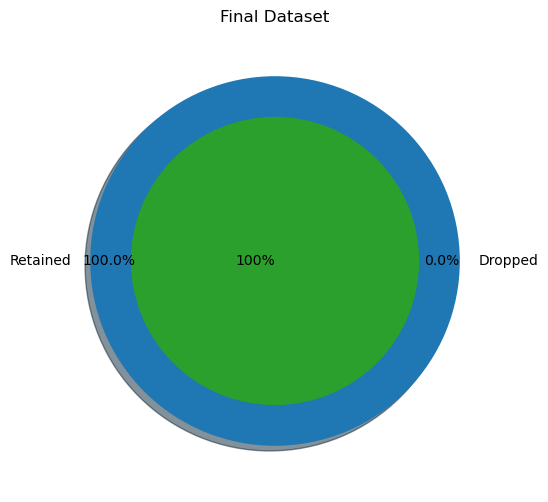


Inference: After the cleanup process, 0 samples were dropped, while retaining 0.0% of the data.


In [16]:
#Final Dataset size after performing Preprocessing

df = df1.copy()
df.columns=[i.replace('-','_') for i in df.columns]

plt.title('Final Dataset')
plt.pie([df.shape[0], original_df.shape[0]-df.shape[0]], radius = 1, labels=['Retained','Dropped'], counterclock=False, 
        autopct='%1.1f%%', pctdistance=0.9, explode=[0,0], shadow=True)
plt.pie([df.shape[0]], labels=['100%'], labeldistance=-0, radius=0.78)
plt.show()

print(f'\n\033[1mInference:\033[0m After the cleanup process, {original_df.shape[0]-df.shape[0]} samples were dropped, \
while retaining {round(100 - (df.shape[0]*100/(original_df.shape[0])),2)}% of the data.')

In [17]:
# Data Manipulation
#Splitting the data intro training & testing sets

m=[]
for i in df.columns.values:
    m.append(i.replace(' ','_'))
    
df.columns = m
X = df.drop([target],axis=1)
Y = df[target]
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=100)
Train_X.reset_index(drop=True,inplace=True)

print('Original set  ---> ',X.shape,Y.shape,'\nTraining set  ---> ',Train_X.shape,Train_Y.shape,'\nTesting set   ---> ', Test_X.shape,'', Test_Y.shape)

Original set  --->  (100, 2) (100,) 
Training set  --->  (80, 2) (80,) 
Testing set   --->  (20, 2)  (20,)


In [18]:
#Feature Scaling (Standardization)

std = StandardScaler()

print('\033[1mStandardardization on Training set'.center(120))
Train_X_std = std.fit_transform(Train_X)
Train_X_std = pd.DataFrame(Train_X_std, columns=X.columns)
display(Train_X_std.describe())

print('\n','\033[1mStandardardization on Testing set'.center(120))
Test_X_std = std.transform(Test_X)
Test_X_std = pd.DataFrame(Test_X_std, columns=X.columns)
display(Test_X_std.describe())

                                         Standardardization on Training set                                         


,number_courses,time_study
count,8.000000e+01,8.000000e+01
mean,3.608225e-17,-4.128642e-17
std,1.006309e+00,1.006309e+00
min,-1.231606e+00,-1.710350e+00
25%,-6.842257e-01,-8.638663e-01
50%,-1.368451e-01,-1.695124e-02
75%,9.579160e-01,8.807528e-01
max,1.505297e+00,1.680330e+00



                                          Standardardization on Testing set                                          


,number_courses,time_study
count,20.000000,20.000000
mean,0.109476,0.034161
std,0.913788,1.116633
min,-1.231606,-1.691372
25%,-0.684226,-0.709127
50%,0.410535,0.098861
75%,0.547381,0.965293
max,1.505297,1.501759


                                       Correlation Matrix                                       


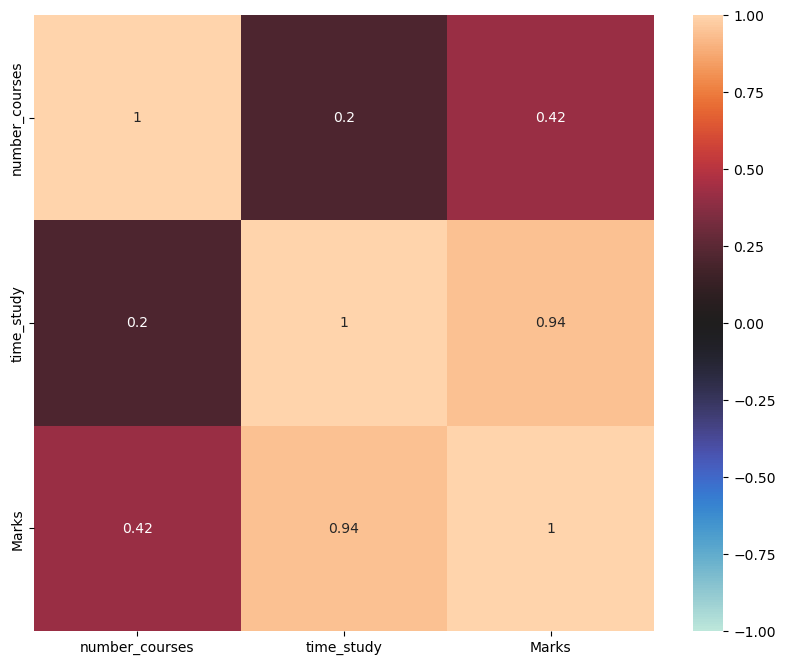

In [19]:
#Feature Selection/Extraction
#Checking the correlation

print('\033[1mCorrelation Matrix'.center(100))
plt.figure(figsize=[10,8])
sns.heatmap(df.corr(), annot=True, vmin=-1, vmax=1, center=0) #cmap='BuGn'
plt.show()

In [20]:
#Testing a Linear Regression model with statsmodels

Train_xy = pd.concat([Train_X_std,Train_Y.reset_index(drop=True)],axis=1)
a = Train_xy.columns.values

API = api.ols(formula='{} ~ {}'.format(target,' + '.join(i for i in Train_X.columns)), data=Train_xy).fit()
#print(API.conf_int())
#print(API.pvalues)
API.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Marks   R-squared:                       0.940
Model:                            OLS   Adj. R-squared:                  0.939
Method:                 Least Squares   F-statistic:                     608.0
Date:                Fri, 27 Jan 2023   Prob (F-statistic):           6.80e-48
Time:                        03:05:55   Log-Likelihood:                -213.09
No. Observations:                  80   AIC:                             432.2
Df Residuals:                      77   BIC:                             439.3
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         24.1342      0.396     60.995      0.000      23.346      24.922
number_courses     3.4621      0.403      8.582      0.000       2.659       4.265
time_study        12.6998      0.403     31.482      0.000      11.897      13.503
==============================================================================
Omnibus:                       15.900   Durbin-Watson:                   1.857
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                7.875
Skew:                           0.574   Prob(JB):                       0.0195
Kurtosis:                       1.977   Cond. No.                         1.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Dropped Features -->  ['number_courses']


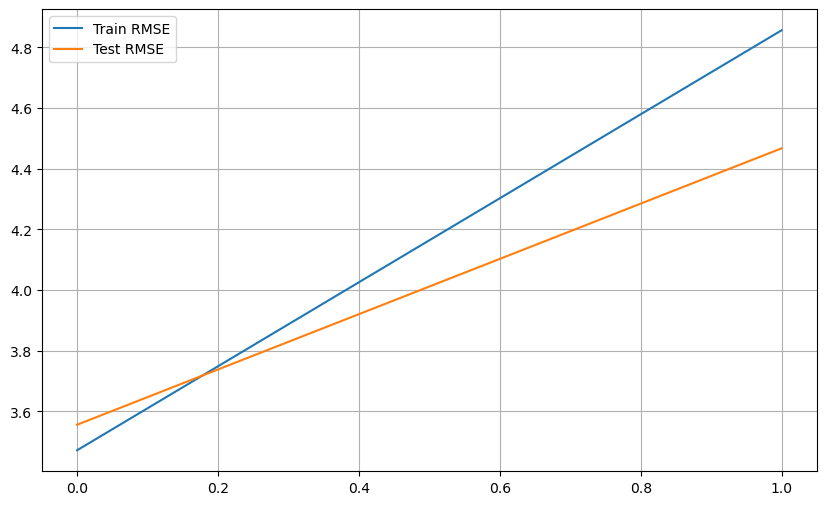

In [22]:
#Manual Method - VIF
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]

DROP=[];b=[]

LR = LinearRegression()
LR.fit(Train_X_std, Train_Y)

pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))

Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

for i in range(len(Train_X_std.columns)-1):
    vif = pd.DataFrame()
    X = Train_X_std.drop(DROP,axis=1)
    vif['Features'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif.reset_index(drop=True, inplace=True)
    if vif.loc[0][1]>1:
        DROP.append(vif.loc[0][0])
        LR = LinearRegression()
        LR.fit(Train_X_std.drop(DROP,axis=1), Train_Y)
        pred1 = LR.predict(Train_X_std.drop(DROP,axis=1))
        pred2 = LR.predict(Test_X_std.drop(DROP,axis=1))
        
        Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
        Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

        
print('Dropped Features --> ',DROP)

plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')

plt.legend()
plt.grid()
plt.show()

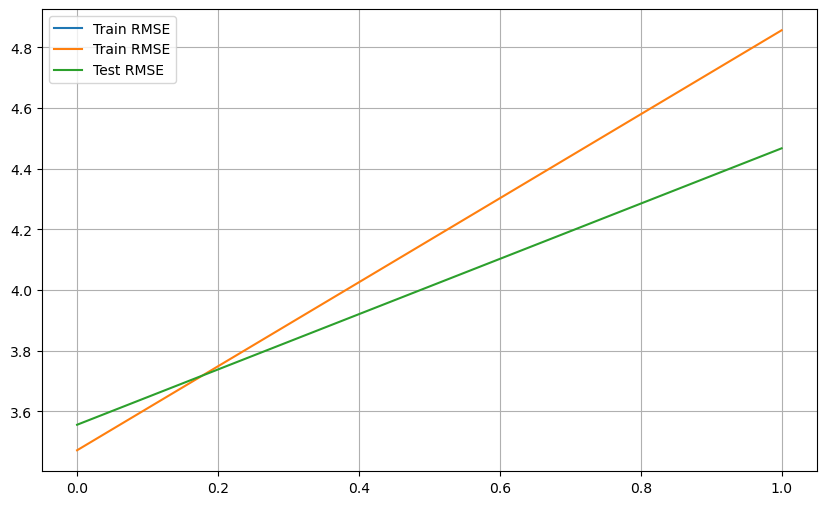

In [23]:
#Automatic Method - RFE
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)

m=df.shape[1]-1
for i in range(m):
    lm = LinearRegression()
    rfe = RFE(lm,n_features_to_select=Train_X_std.shape[1]-i)             # running RFE
    rfe = rfe.fit(Train_X_std, Train_Y)

    LR = LinearRegression()
    LR.fit(Train_X_std.loc[:,rfe.support_], Train_Y)

    pred1 = LR.predict(Train_X_std.loc[:,rfe.support_])
    pred2 = LR.predict(Test_X_std.loc[:,rfe.support_])

    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))
    plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.75,20.75])
plt.legend()
plt.grid()
plt.show()

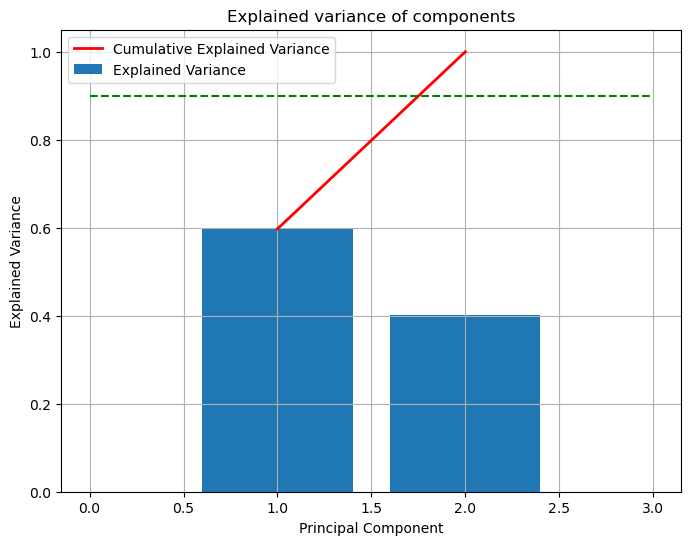

In [24]:
#Feature Elmination using PCA Decomposition¶
from sklearn.decomposition import PCA

pca = PCA().fit(Train_X_std)

fig, ax = plt.subplots(figsize=(8,6))
x_values = range(1, pca.n_components_+1)
ax.bar(x_values, pca.explained_variance_ratio_, lw=2, label='Explained Variance')
ax.plot(x_values, np.cumsum(pca.explained_variance_ratio_), lw=2, label='Cumulative Explained Variance', color='red')
plt.plot([0,pca.n_components_+1],[0.9,0.9],'g--')
ax.set_title('Explained variance of components')
ax.set_xlabel('Principal Component')
ax.set_ylabel('Explained Variance')
plt.legend()
plt.grid()
plt.show()

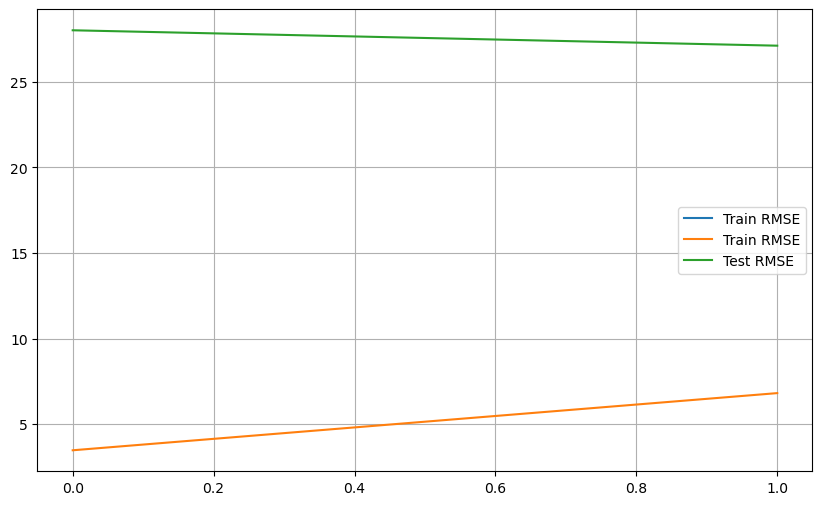

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
Trr=[]; Tss=[]; n=3
order=['ord-'+str(i) for i in range(2,n)]
Trd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
Tsd = pd.DataFrame(np.zeros((10,n-2)), columns=order)
m=df.shape[1]-1

for i in range(m):
    pca = PCA(n_components=Train_X_std.shape[1]-i)
    Train_X_std_pca = pca.fit_transform(Train_X_std)
    Test_X_std_pca = pca.fit_transform(Test_X_std)
    
    LR = LinearRegression()
    LR.fit(Train_X_std_pca, Train_Y)

    pred1 = LR.predict(Train_X_std_pca)
    pred2 = LR.predict(Test_X_std_pca)

    Trr.append(round(np.sqrt(mean_squared_error(Train_Y, pred1)),2))
    Tss.append(round(np.sqrt(mean_squared_error(Test_Y, pred2)),2))
    plt.plot(Trr, label='Train RMSE')
plt.plot(Tss, label='Test RMSE')
#plt.ylim([19.5,20.75])
plt.legend()
plt.grid()
plt.show()

In [29]:
#Predictive Modelling
#Let us first define a function to evaluate our models

Model_Evaluation_Comparison_Matrix = pd.DataFrame(np.zeros([5,8]), columns=['Train-R2','Test-R2','Train-RSS','Test-RSS',
                                                                            'Train-MSE','Test-MSE','Train-RMSE','Test-RMSE'])
rc=np.random.choice(Train_X_std.loc[:,Train_X_std.nunique()>=50].columns.values,1,replace=False)
def Evaluate(n, pred1,pred2):
    #Plotting predicted predicteds alongside the actual datapoints 
    plt.figure(figsize=[15,6])
    for e,i in enumerate(rc):
        plt.subplot(2,3,e+1)
        plt.scatter(y=Train_Y, x=Train_X_std[i], label='Actual')
        plt.scatter(y=pred1, x=Train_X_std[i], label='Prediction')
        plt.legend()
    plt.show()

    #Evaluating the Multiple Linear Regression Model
    print('\n{}Training Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Training set --->',round(r2_score(Train_Y, pred1),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Train_Y-pred1)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Train_Y, pred1),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Train_Y, pred1)),20))

    print('\n{}Testing Set Metrics{}'.format('-'*20, '-'*20))
    print('\nR2-Score on Testing set --->',round(r2_score(Test_Y, pred2),20))
    print('Residual Sum of Squares (RSS) on Training set  --->',round(np.sum(np.square(Test_Y-pred2)),20))
    print('Mean Squared Error (MSE) on Training set       --->',round(mean_squared_error(Test_Y, pred2),20))
    print('Root Mean Squared Error (RMSE) on Training set --->',round(np.sqrt(mean_squared_error(Test_Y, pred2)),20))
    print('\n{}Residual Plots{}'.format('-'*20, '-'*20))
    
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-R2']  = round(r2_score(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-R2']   = round(r2_score(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RSS'] = round(np.sum(np.square(Train_Y-pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RSS']  = round(np.sum(np.square(Test_Y-pred2)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-MSE'] = round(mean_squared_error(Train_Y, pred1),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-MSE']  = round(mean_squared_error(Test_Y, pred2),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Train-RMSE']= round(np.sqrt(mean_squared_error(Train_Y, pred1)),20)
    Model_Evaluation_Comparison_Matrix.loc[n,'Test-RMSE'] = round(np.sqrt(mean_squared_error(Test_Y, pred2)),20)
    # Plotting y_test and y_pred to understand the spread.
    plt.figure(figsize=[15,4])

    plt.subplot(1,2,1)
    sns.distplot((Train_Y - pred1))
    plt.title('Error Terms')          
    plt.xlabel('Errors') 

    plt.subplot(1,2,2)
    plt.scatter(Train_Y,pred1)
    plt.plot([Train_Y.min(),Train_Y.max()],[Train_Y.min(),Train_Y.max()], 'r--')
    plt.title('Test vs Prediction')         
    plt.xlabel('y_test')                       
    plt.ylabel('y_pred')                       
    plt.show()


<<<----------------------------------- Evaluating Multiple Linear Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 3.46211647 12.69982433]
The Intercept of the Regresion Model was found to be  24.1342


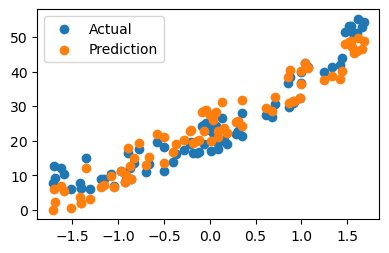


--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9404526569528092
Residual Sum of Squares (RSS) on Training set  ---> 964.4065702195884
Mean Squared Error (MSE) on Training set       ---> 12.055082127744857
Root Mean Squared Error (RMSE) on Training set ---> 3.472042932877538

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9381738467744822
Residual Sum of Squares (RSS) on Training set  ---> 252.92972489462693
Mean Squared Error (MSE) on Training set       ---> 12.646486244731346
Root Mean Squared Error (RMSE) on Training set ---> 3.5561898493656585

--------------------Residual Plots--------------------


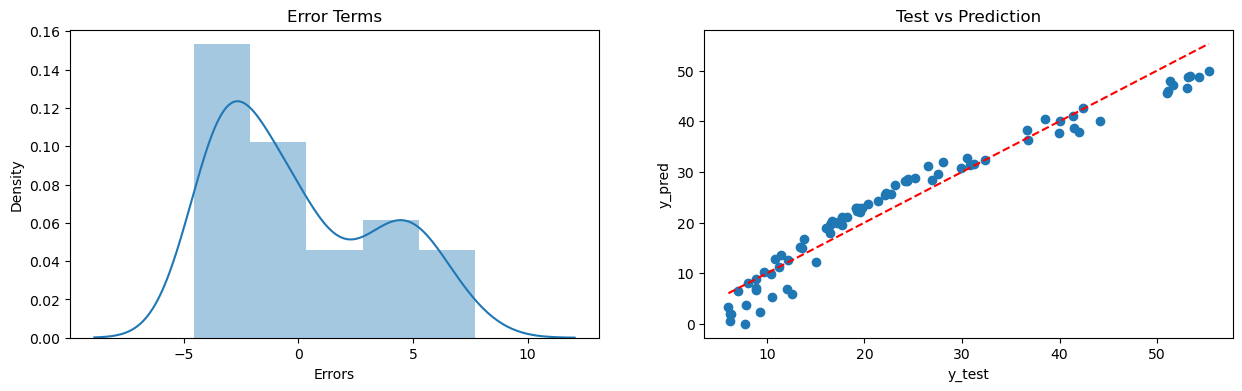

In [30]:
#Multiple Linear Regression(MLR)


#Linear Regression

MLR = LinearRegression().fit(Train_X_std,Train_Y)
pred1 = MLR.predict(Train_X_std)
pred2 = MLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Multiple Linear Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(0, pred1, pred2)

<<<----------------------------------- Evaluating Ridge Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 3.46211647 12.69982433]
The Intercept of the Regresion Model was found to be  24.1342


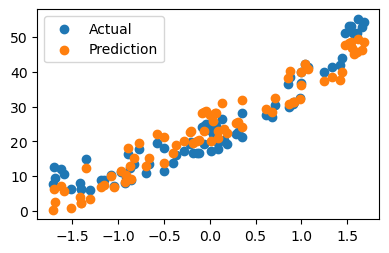


--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9403303674178298
Residual Sum of Squares (RSS) on Training set  ---> 966.3871259416077
Mean Squared Error (MSE) on Training set       ---> 12.079839074270097
Root Mean Squared Error (RMSE) on Training set ---> 3.475606288731521

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9395944471864459
Residual Sum of Squares (RSS) on Training set  ---> 247.11807314795342
Mean Squared Error (MSE) on Training set       ---> 12.355903657397674
Root Mean Squared Error (RMSE) on Training set ---> 3.5150965359997826

--------------------Residual Plots--------------------


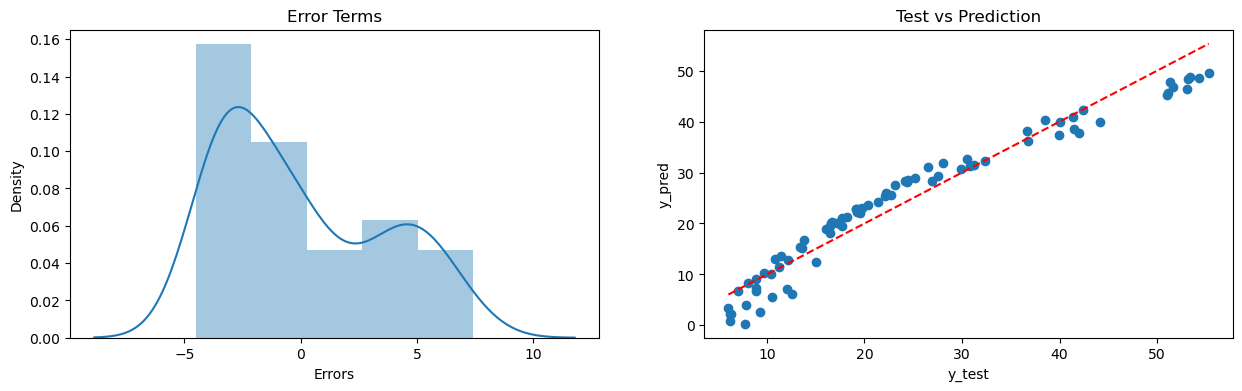

In [31]:
#Ridge Regression Model

#Creating a Ridge Regression model

RLR = Ridge().fit(Train_X_std,Train_Y)
pred1 = RLR.predict(Train_X_std)
pred2 = RLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Ridge Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(1, pred1, pred2)

<<<----------------------------------- Evaluating Lasso Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 3.46211647 12.69982433]
The Intercept of the Regresion Model was found to be  24.1342


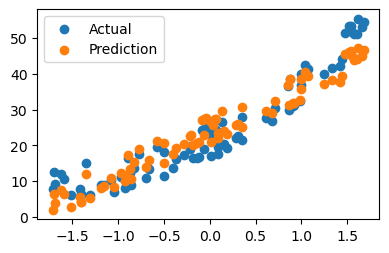


--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9321832792587026
Residual Sum of Squares (RSS) on Training set  ---> 1098.3343287344148
Mean Squared Error (MSE) on Training set       ---> 13.729179109180187
Root Mean Squared Error (RMSE) on Training set ---> 3.705290691589552

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9415034766890258
Residual Sum of Squares (RSS) on Training set  ---> 239.30826642842504
Mean Squared Error (MSE) on Training set       ---> 11.965413321421252
Root Mean Squared Error (RMSE) on Training set ---> 3.459105855769848

--------------------Residual Plots--------------------


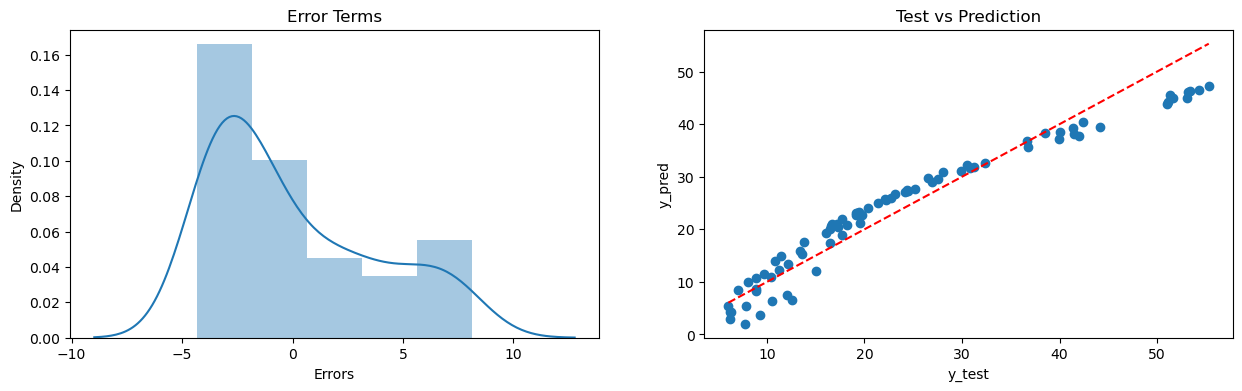

In [32]:
#Lasso Regression Model


#Creating a Ridge Regression model

LLR = Lasso().fit(Train_X_std,Train_Y)
pred1 = LLR.predict(Train_X_std)
pred2 = LLR.predict(Test_X_std)

print('{}{}\033[1m Evaluating Lasso Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(2, pred1, pred2)

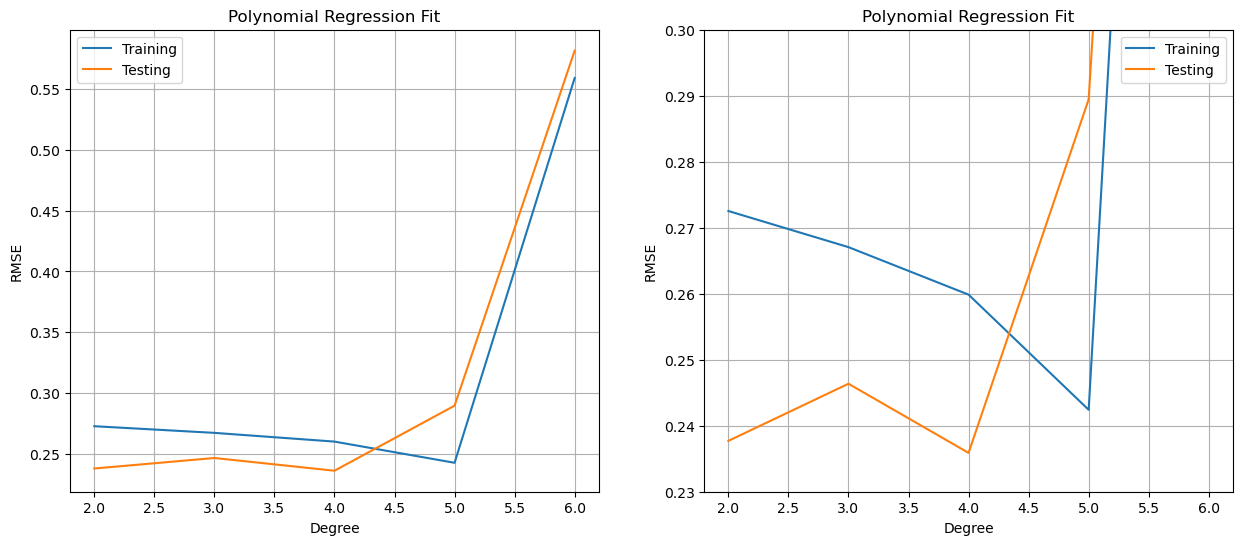

In [33]:
#Checking polynomial regression performance on various degrees

Trr=[]; Tss=[]
n_degree=7

for i in range(2,n_degree):
    #print(f'{i} Degree')
    poly_reg = PolynomialFeatures(degree=i)
    X_poly = poly_reg.fit_transform(Train_X_std)
    X_poly1 = poly_reg.fit_transform(Test_X_std)
    LR = LinearRegression()
    LR.fit(X_poly, Train_Y)
    
    pred1 = LR.predict(X_poly)
    Trr.append(np.sqrt(mean_squared_error(Train_Y, pred1)))
    
    pred2 = LR.predict(X_poly1)
    Tss.append(np.sqrt(mean_squared_error(Test_Y, pred2)))

plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
#plt.plot([1,4],[1,4],'b--')
plt.title('Polynomial Regression Fit')
#plt.ylim([0,5])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()

plt.subplot(1,2,2)
plt.plot(range(2,n_degree),Trr, label='Training')
plt.plot(range(2,n_degree),Tss, label='Testing')
plt.title('Polynomial Regression Fit')
plt.ylim([0.23,0.3])
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.grid()
plt.legend()
#plt.xticks()
plt.show()

<<<----------------------------------- Evaluating Polynomial Regression Model ----------------------------------->>>

The Coeffecient of the Regresion Model was found to be  [ 3.46211647 12.69982433]
The Intercept of the Regresion Model was found to be  24.1342


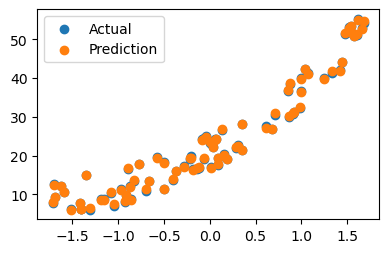


--------------------Training Set Metrics--------------------

R2-Score on Training set ---> 0.9997097318617344
Residual Sum of Squares (RSS) on Training set  ---> 4.701074562588255
Mean Squared Error (MSE) on Training set       ---> 0.0587634320323532
Root Mean Squared Error (RMSE) on Training set ---> 0.24241169945436458

--------------------Testing Set Metrics--------------------

R2-Score on Testing set ---> 0.9995903927979447
Residual Sum of Squares (RSS) on Training set  ---> 1.675695988278916
Mean Squared Error (MSE) on Training set       ---> 0.0837847994139458
Root Mean Squared Error (RMSE) on Training set ---> 0.2894560405552902

--------------------Residual Plots--------------------


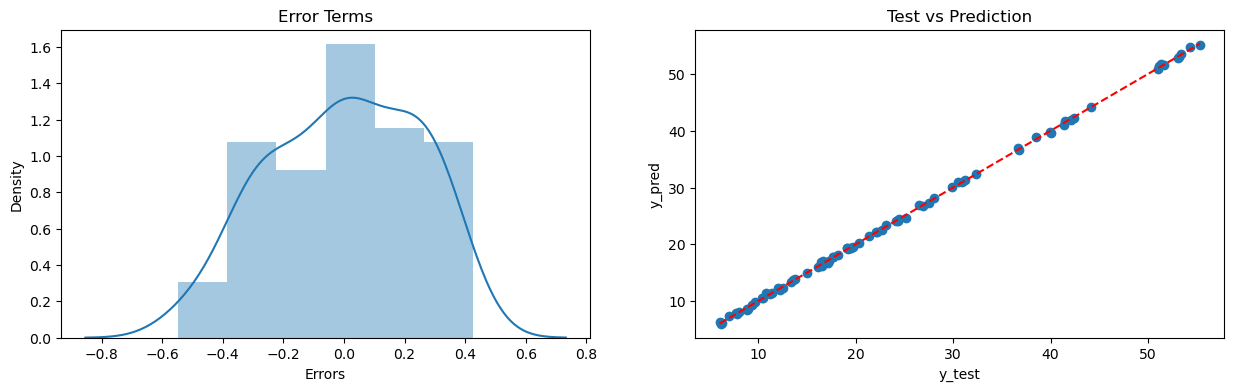

In [34]:
#Using the 5th Order Polynomial Regression model (degree=5)

poly_reg = PolynomialFeatures(degree=5)
X_poly = poly_reg.fit_transform(Train_X_std)
X_poly1 = poly_reg.fit_transform(Test_X_std)
PR = LinearRegression()
PR.fit(X_poly, Train_Y)

pred1 = PR.predict(X_poly)
pred2 = PR.predict(X_poly1)

print('{}{}\033[1m Evaluating Polynomial Regression Model \033[0m{}{}\n'.format('<'*3,'-'*35 ,'-'*35,'>'*3))
print('The Coeffecient of the Regresion Model was found to be ',MLR.coef_)
print('The Intercept of the Regresion Model was found to be ',MLR.intercept_)

Evaluate(4, pred1, pred2)

In [37]:
# Regression Models Results Evaluation

EMC = Model_Evaluation_Comparison_Matrix.copy()
EMC.index = ['Multiple Linear Regression (MLR)','Ridge Linear Regression (RLR)','Lasso Linear Regression (LLR)','Elastic-Net Regression (ENR)','Polynomial Regression (PNR)']
EMC

,Train-R2,Test-R2,Train-RSS,Test-RSS,Train-MSE,Test-MSE,Train-RMSE,Test-RMSE
Multiple Linear Regression (MLR),0.940453,0.938174,964.406570,252.929725,12.055082,12.646486,3.472043,3.556190
Ridge Linear Regression (RLR),0.940330,0.939594,966.387126,247.118073,12.079839,12.355904,3.475606,3.515097
Lasso Linear Regression (LLR),0.932183,0.941503,1098.334329,239.308266,13.729179,11.965413,3.705291,3.459106
Elastic-Net Regression (ENR),0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Polynomial Regression (PNR),0.999710,0.999590,4.701075,1.675696,0.058763,0.083785,0.242412,0.289456
